In [2]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

树构建模块 _tree.* 详解
=====================

### 0. 大纲

此模块包含两种类，一种是二叉树的实现类 `Tree`，另一种是构建出整颗树的方法类 `TreeBuilder`。我们着重介绍构建方法类 `TreeBuilder`，最后会简要提及 `Tree` 的几个函数。 

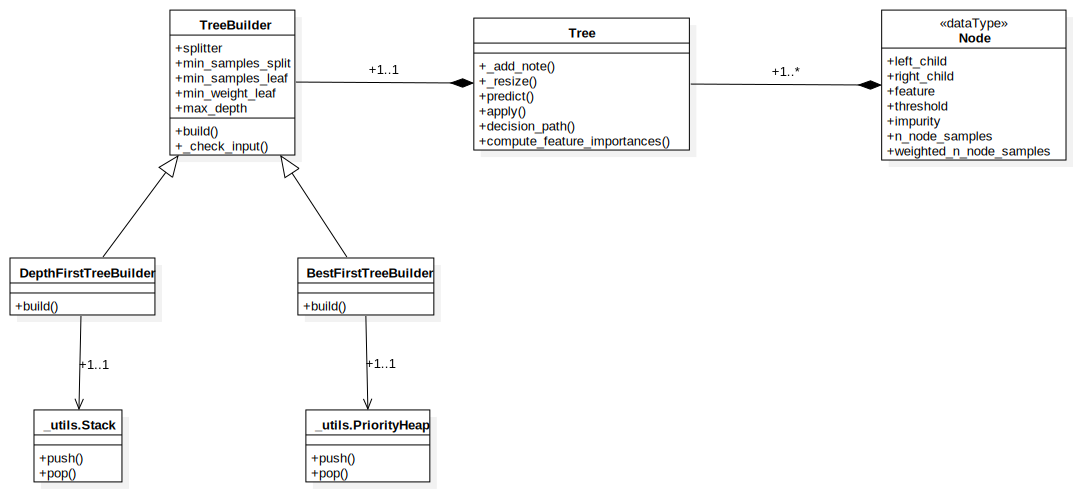

In [3]:
SVG("./res/uml/Model___tree_3.svg")

### 1. 构建类

#### 1.0 TreeBuilder
TreeBuilder 提供了接口方法 `build` 和一个具体的参数检查方法 `_check_input`，没太多说的。

#### 1.1 DepthFirstTreeBuilder
DepthFirstTreeBuilder 是用类似先序遍历的方式生成整颗决策树，借助的数据结构是先进先出栈。

主要流程是：

1. 从栈中抽出一个节点
2. 计算分割点
   + 若达到叶子条件，不再处理；
   + 若不是叶子，则先压右叶子入栈，再压左叶子入栈。
3. 若栈空，树构建完成。

主体代码如下：

```Python
 195         with nogil:
 196             # push root node onto stack
 197             rc = stack.push(0, n_node_samples, 0, _TREE_UNDEFINED, 0, INFINITY, 0)
 198 #+--  4 lines: if rc == -1:-----------------------------------------------------------------
 202
 203             while not stack.is_empty():
 204                 stack.pop(&stack_record)
 205 #+--  9 lines: start = stack_record.start---------------------------------------------------
 214                 n_node_samples = end - start
 215                 splitter.node_reset(start, end, &weighted_n_node_samples)
 216
 217                 is_leaf = ((depth >= max_depth) or
 218                            (n_node_samples < min_samples_split) or
 219                            (n_node_samples < 2 * min_samples_leaf) or
 220                            (weighted_n_node_samples < min_weight_leaf))
 221
 222                 if first:
 223                     impurity = splitter.node_impurity()
 224                     first = 0
 225
 226                 is_leaf = is_leaf or (impurity <= MIN_IMPURITY_SPLIT)
 227
 228                 if not is_leaf:
 229                     splitter.node_split(impurity, &split, &n_constant_features)
 230                     is_leaf = is_leaf or (split.pos >= end)
 231
 232                 node_id = tree._add_node(parent, is_left, is_leaf, split.feature,
 233                                          split.threshold, impurity, n_node_samples,
 234                                          weighted_n_node_samples)
 235
 236 #+--  4 lines: if node_id == <SIZE_t>(-1):--------------------------------------------------
 240                 # Store value for all nodes, to facilitate tree/model
 241                 # inspection and interpretation
 242                 splitter.node_value(tree.value + node_id * tree.value_stride)
 243
 244                 if not is_leaf:
 245                     # Push right child on stack
 246                     rc = stack.push(split.pos, end, depth + 1, node_id, 0,
 247                                     split.impurity_right, n_constant_features)
 248 #+--  3 lines: if rc == -1:-----------------------------------------------------------------
 251                     # Push left child on stack
 252                     rc = stack.push(start, split.pos, depth + 1, node_id, 1,
 253                                     split.impurity_left, n_constant_features)
 254 #+--  2 lines: if rc == -1:-----------------------------------------------------------------
 256
```

#### 1.2 BestFirstTreeBuilder

BestFristTreeBuilder 总是优先分割最混杂（不纯度最大）的节点，借助了最大堆的数据结构。处理流程和 DepthFirstTreeBuilder 大同小异，不赘述。